In [8]:
import numpy as np
from qocag import grape_schroedinger_discrete
from qocag.costs.targetstateinfidelity import TargetStateInfidelity
from qocag import ControlVariation,generate_save_file_path,ControlBandwidthMax
from qocag import LBFGSB,Adam
import matplotlib.pyplot as plt
def get_creation_operator(size):
    return np.diag(np.sqrt(np.arange(1, size)), k=-1)
def get_annihilation_operator(size):
    return np.diag(np.sqrt(np.arange(1, size)), k=1)
def get_H(dim_c,dim_t,chi):
    a_dag=get_creation_operator(dim_c)
    a=get_annihilation_operator(dim_c)
    CX=np.kron(a+a_dag,np.identity(dim_t))
    sigmam=get_annihilation_operator(dim_t)
    sigmap=get_creation_operator(dim_t)
    sigmax=sigmam+sigmap
    sigmay=-1j*sigmap+1j*sigmam
    H=chi*np.kron(a_dag.dot(a),sigmap.dot(sigmam))
    SX=np.kron(np.identity(dim_c),sigmax)
    SY=np.kron(np.identity(dim_c),sigmay)
    return H,[SX,SY,CX]

In [36]:
dim_c=5
dim_t=2
chi=0.1**2/3*2*np.pi
initial_state_c=np.zeros(dim_c)
initial_state_c[0]=1
target_state_c=np.zeros(dim_c)
target_state_c[1]=1
state_t=np.zeros(dim_t)
state_t[0]=1
initial_states=np.kron(initial_state_c,state_t)
target_states=np.kron(target_state_c,state_t)
cost1=TargetStateInfidelity(target_states=target_states)
costs=[cost1]

total_time=400
total_time_steps=100

In [10]:
chi/np.pi/2*3

0.010000000000000002

In [11]:
H0,H_controls=get_H(dim_c,dim_t,chi)

In [525]:
def impose_bc(controls):
    max_control=[6*2*np.pi/10,6*2*np.pi/10,3*2*np.pi/10]
    for i in range(len(controls)):
        controls[i][0]=0
        controls[i][-1]=0
        for j in range(len(controls[0])-1):
            if controls[i][j+1]>max_control[i]:
                controls[i][j+1]=max_control[i]
            if controls[i][j+1]<-max_control[i]:
                controls[i][j+1]=-max_control[i]
    return controls

In [526]:
initial_control=0.0001*np.ones((3,total_time_steps))
save_file_path=generate_save_file_path("fock2","./out")
result=grape_schroedinger_discrete(total_time_steps,
                                costs, total_time, H0, H_controls,
                                initial_states,max_iteration_num=1000,
                                optimizer=Adam(), mode='AD', tol=1e-15,initial_controls=initial_control,save_file_path=save_file_path,
                                   impose_control_conditions=impose_bc)

iter   |   total error  |       cost0      |   grads_l2  
  1    | 9.99998822e-01 |  9.99998822e-01  |  4.80480325e-03  
  2    | 9.86278426e-01 |  9.86278426e-01  |  4.61758886e+00  
  3    | 9.19729870e-01 |  9.19729870e-01  |  1.31435604e+01  
  4    | 8.05566191e-01 |  8.05566191e-01  |  1.44358355e+01  
  5    | 7.18052048e-01 |  7.18052048e-01  |  4.93007181e+00  
  6    | 7.13291968e-01 |  7.13291968e-01  |  2.85980076e+00  
  7    | 7.28233333e-01 |  7.28233333e-01  |  2.15978766e+00  
  8    | 7.23870780e-01 |  7.23870780e-01  |  2.82862768e+00  
  9    | 6.94920797e-01 |  6.94920797e-01  |  5.87644513e+00  
  10   | 6.44296820e-01 |  6.44296820e-01  |  7.07658809e+00  
  11   | 5.98282772e-01 |  5.98282772e-01  |  5.60363403e+00  
  12   | 5.92109061e-01 |  5.92109061e-01  |  1.21585098e+01  
  13   | 5.85372876e-01 |  5.85372876e-01  |  1.63955352e+01  
  14   | 5.42709753e-01 |  5.42709753e-01  |  1.36818074e+01  
  15   | 4.95017021e-01 |  4.95017021e-01  |  7.37063504e+00

 131   | 5.25627305e-06 |  5.25627305e-06  |  4.25046953e-02  
 132   | 3.98529529e-06 |  3.98529529e-06  |  4.33703373e-02  
 133   | 3.33216067e-06 |  3.33216067e-06  |  3.67718864e-02  
 134   | 3.48453946e-06 |  3.48453946e-06  |  3.56359193e-02  
 135   | 4.16100757e-06 |  4.16100757e-06  |  4.94772806e-02  
 136   | 4.54272156e-06 |  4.54272156e-06  |  3.48959044e-02  
 137   | 4.72673191e-06 |  4.72673191e-06  |  5.04617981e-02  
 138   | 4.28407300e-06 |  4.28407300e-06  |  4.81726409e-02  


KeyboardInterrupt: 

In [12]:
import qutip as qt

In [123]:
qt_H0=qt.Qobj(H0)
qt_Hc1=qt.Qobj(H_controls[0])
qt_Hc2=qt.Qobj(H_controls[1])
qt_Hc3=qt.Qobj(H_controls[2])
qt_is=qt.Qobj(initial_states)
qt_N=100*total_time_steps
qt_t=total_time*1000
qt_tlist=np.linspace(0,qt_t,qt_N)
omega=chi/5
epsilon=omega/30
qt_c1=omega*np.cos(2*chi*qt_tlist)
qt_c2=omega*np.sin(2*chi*qt_tlist)
qt_c3=epsilon*np.ones(qt_N)
qt_H=[qt_H0,[qt_Hc1,qt_c1],[qt_Hc2,qt_c2],[qt_Hc3,qt_c3]]
p2=np.zeros(len(initial_states))
p2[4]=1
p2=qt.Qobj(p2).proj()
p0=qt_is.proj()
p1=qt.Qobj(target_states).proj()
p3=np.zeros(len(initial_states))
p3[6]=1
p3=qt.Qobj(p3).proj()
p4=np.zeros(len(initial_states))
p4[8]=1
p4=qt.Qobj(p4).proj()
e_ops=[p0,p1,p2,p3,p4]


In [124]:
result=qt.sesolve(H=qt_H, psi0=qt_is, tlist=qt_tlist,e_ops=e_ops)

In [125]:
max(result.expect[1])

0.34172930917457156

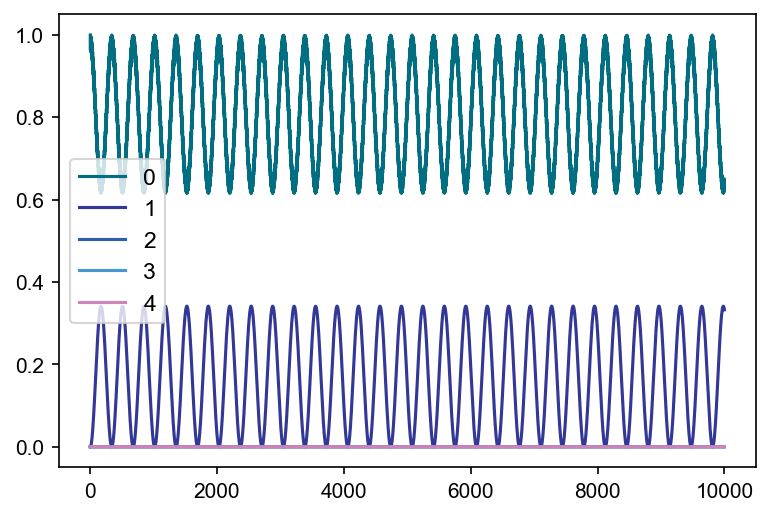

In [126]:
fig,ax=plt.subplots()
for i in range(5):
    ax.plot(result.expect[i],label=str(i))
ax.legend()

In [53]:
qt_t

400000

In [54]:
chi-omega

0.018849555921538762